In [1]:
!pip install node2vec -q
import pandas as pd
import networkx as nx
from node2vec import Node2Vec
import torch
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
from imblearn.over_sampling import SMOTE
import xgboost as xgb
from sklearn.preprocessing import StandardScaler

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [3]:
# Paso 1: Cargar datos y crear un grafo bipartito
from google.colab import drive
drive.mount('/content/drive')

file_path = '/content/drive/MyDrive/Topicos Avanzados A/fraudTrain.csv'
df = pd.read_csv(file_path)

Mounted at /content/drive


In [4]:
# Crear grafo bipartito
B = nx.Graph()

# Agregar nodos y aristas
for index, row in df.iterrows():
    B.add_node(str(row['cc_num']), bipartite=0)  # Nodos de tarjetas
    B.add_node(str(row['merchant']), bipartite=1)  # Nodos de comerciantes
    B.add_edge(str(row['cc_num']), str(row['merchant']),
               is_fraud=row['is_fraud'],
               weight=row['amt'])

In [5]:

# Guardar el grafo en formato GEXF para Gephi
nx.write_gexf(B, "grafo_bipartito.gexf")


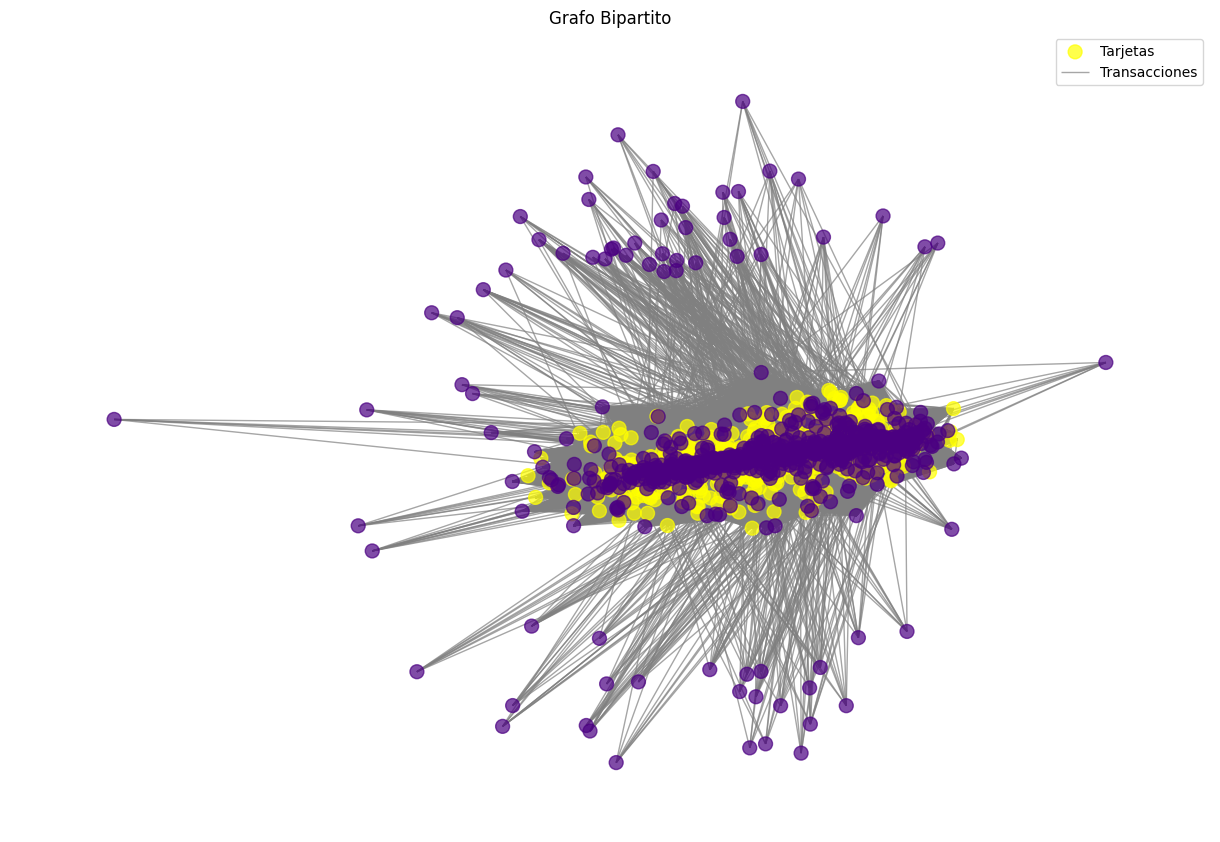

In [6]:

import matplotlib.pyplot as plt
import seaborn as sns

# Obtener nodos de tarjetas y comerciantes
card_nodes = [node for node, data in B.nodes(data=True) if data['bipartite'] == 0]
merchant_nodes = [node for node, data in B.nodes(data=True) if data['bipartite'] == 1]

# Crear un mapa de colores para los nodos
node_colors = ['yellow'] * len(card_nodes) + ['indigo'] * len(merchant_nodes)

# Dibujar el grafo con seaborn
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(B)  # Puedes usar otros layouts
nx.draw(B, pos, node_color=node_colors, with_labels=False, node_size=100, edge_color='gray', alpha=0.7)

# Agregar leyenda para los colores de los nodos
plt.legend(['Tarjetas', 'Transacciones', 'Comerciantes'], loc='upper right')

plt.title('Grafo Bipartito')
plt.show()



In [7]:

# Configurar y entrenar Node2Vec
node2vec = Node2Vec(B,
                    dimensions=128,     # Aumentado para capturar más información
                    walk_length=20,     # Paseos más largos
                    num_walks=80,      # Más paseos
                    workers=4,          # Más workers para velocidad
                    p=1,            # Favorece exploración local
                    q=1)               # Favorece exploración más amplia

model = node2vec.fit(window=10,
                     min_count=1,
                     batch_words=4,
                     epochs=10)         # Más épocas de entrenamiento


Computing transition probabilities:   0%|          | 0/1676 [00:00<?, ?it/s]

In [8]:

# Obtener embeddings de nodos
node_embeddings = {str(node): torch.tensor(model.wv[str(node)], dtype=torch.float32)
                  for node in B.nodes()}

In [9]:

# Función mejorada para calcular average embeddings
def calculate_average_embeddings(u, v, node_embeddings):
    u_emb = node_embeddings[str(u)]
    v_emb = node_embeddings[str(v)]
    # Promedio ponderado de embeddings
    avg_emb = (u_emb + v_emb) / 2
    # Concatenar embeddings individuales con el promedio
    combined_emb = torch.cat([u_emb, v_emb, avg_emb])
    return combined_emb

In [12]:

# Preparar datos para entrenamiento
edge_data = []
labels = []

for u, v, data in B.edges(data=True):
    if 'is_fraud' in data and not pd.isnull(data['is_fraud']):
        try:
            # Calcular embedding combinado para la arista
            edge_emb = calculate_average_embeddings(u, v, node_embeddings)
            edge_data.append(edge_emb.detach().numpy())
            labels.append(data['is_fraud'])
        except KeyError:
            continue

X = np.array(edge_data)
y = np.array(labels)

# Normalizar los datos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Balanceo de clases con SMOTE
smote = SMOTE(random_state=88, sampling_strategy=0.5)  # Aumentar la proporción de casos fraudulentos
X_resampled, y_resampled = smote.fit_resample(X_scaled, y)


# Dividir en train y test+validation
X_train, X_temp, y_train, y_temp = train_test_split(X_resampled,
                                                   y_resampled,
                                                   test_size=0.2,
                                                   random_state=42,
                                                   stratify=y_resampled)

# Dividir test+validation en test y validation
X_test, X_val, y_test, y_val = train_test_split(X_temp,
                                                y_temp,
                                                test_size=0.5,
                                                random_state=88,
                                                stratify=y_temp)





In [13]:
# Configurar y entrenar XGBoost
xgb_params = {
    'objective': 'binary:logistic',
    'max_depth': 6,
    'learning_rate': 0.01,
    'n_estimators': 1000,
    'min_child_weight': 1,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'gamma': 0.1,
    'scale_pos_weight': 1,  # Ya balanceamos con SMOTE
    'random_state': 88
}



model = xgb.XGBClassifier(**xgb_params)
model.fit(X_train, y_train,
          eval_set=[(X_test, y_test)],
          verbose= 100)




[0]	validation_0-logloss:0.63476
[100]	validation_0-logloss:0.52506
[200]	validation_0-logloss:0.46861
[300]	validation_0-logloss:0.42707
[400]	validation_0-logloss:0.39347
[500]	validation_0-logloss:0.36512
[600]	validation_0-logloss:0.34044
[700]	validation_0-logloss:0.31726
[800]	validation_0-logloss:0.29709
[900]	validation_0-logloss:0.27986
[999]	validation_0-logloss:0.26422


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.1, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=1000, n_jobs=None,
              num_parallel_tree=None, random_state=88, ...)

In [14]:
#Entrenamiento conjunto de validación

model = xgb.XGBClassifier(**xgb_params)
model.fit(X_train, y_train,
          eval_set=[(X_val, y_val)],  # Agregar el conjunto de validación
          verbose=100)

[0]	validation_0-logloss:0.63475
[100]	validation_0-logloss:0.52464
[200]	validation_0-logloss:0.46767
[300]	validation_0-logloss:0.42595
[400]	validation_0-logloss:0.39237
[500]	validation_0-logloss:0.36421
[600]	validation_0-logloss:0.33968
[700]	validation_0-logloss:0.31659
[800]	validation_0-logloss:0.29639
[900]	validation_0-logloss:0.27926
[999]	validation_0-logloss:0.26369


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.1, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=1000, n_jobs=None,
              num_parallel_tree=None, random_state=88, ...)

In [15]:
# Predicciones test
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

In [16]:
# Predicciones validación
y_pred_val = model.predict(X_val)
y_pred_proba_val = model.predict_proba(X_val)[:, 1]

In [17]:

# Evaluación en test
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

accuracy = accuracy_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred_proba)

print(f"\nAccuracy: {accuracy:.4f}")
print(f"AUC: {auc:.4f}")


Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.98      0.94     47534
           1       0.94      0.81      0.87     23767

    accuracy                           0.92     71301
   macro avg       0.93      0.89      0.91     71301
weighted avg       0.92      0.92      0.92     71301


Accuracy: 0.9214
AUC: 0.9784


In [18]:

# Evaluación en validación
print("\nClassification Report (Validación):")
print(classification_report(y_val, y_pred_val))

accuracy_val = accuracy_score(y_val, y_pred_val)
auc_val = roc_auc_score(y_val, y_pred_proba_val)

print(f"\nAccuracy (Validación): {accuracy_val:.4f}")
print(f"AUC (Validación): {auc_val:.4f}")


Classification Report (Validación):
              precision    recall  f1-score   support

           0       0.91      0.97      0.94     47535
           1       0.94      0.82      0.87     23767

    accuracy                           0.92     71302
   macro avg       0.93      0.90      0.91     71302
weighted avg       0.92      0.92      0.92     71302


Accuracy (Validación): 0.9220
AUC (Validación): 0.9784


In [19]:
# Imprimir importancia de características
importance_df = pd.DataFrame({
    'feature': [f'feature_{i}' for i in range(len(model.feature_importances_))],
    'importance': model.feature_importances_
})
print("\nTop 10 características más importantes:")
print(importance_df.sort_values('importance', ascending=False).head(10))


Top 10 características más importantes:
         feature  importance
83    feature_83    0.017854
297  feature_297    0.015981
267  feature_267    0.011963
41    feature_41    0.011124
43    feature_43    0.009255
339  feature_339    0.009228
72    feature_72    0.008923
111  feature_111    0.008586
36    feature_36    0.007863
53    feature_53    0.006835


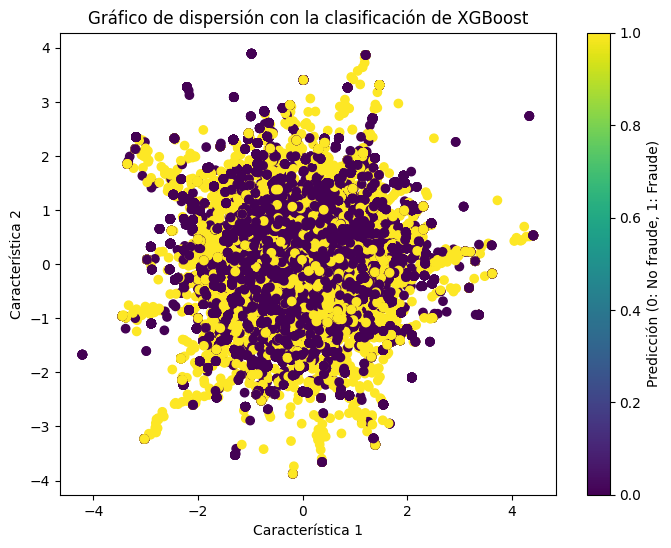

In [20]:

y_pred = model.predict(X_test)

plt.figure(figsize=(8, 6))
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_pred, cmap='viridis')
plt.xlabel('Característica 1')
plt.ylabel('Característica 2')
plt.title('Gráfico de dispersión con la clasificación de XGBoost')
plt.colorbar(label='Predicción (0: No fraude, 1: Fraude)')
plt.show()